In [45]:
import pandas as pd

# Load features and labels
features = pd.read_csv('features/final_feature_matrix.csv')
labels = pd.read_csv('trainLabels.csv')  # from Kaggle dataset

# Merge on Id
df = pd.merge(features, labels, on='Id')
df['Class'] = df['Class'] - 1  # XGBoost requires 0-based labels


In [46]:
X = df.drop(columns=['Id', 'Class'])
y = df['Class']

# Clean column names for compatibility
X.columns = X.columns.astype(str).str.replace(r'[\[\]<>]', '_', regex=True)

# Ensure all values are numeric and float
X = X.apply(pd.to_numeric, errors='coerce')
X.fillna(0, inplace=True)
X = X.astype('float32')  # XGBoost prefers float32


In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [48]:
import xgboost as xgb

model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=9,
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    tree_method='auto',            # 🔑 prevents internal crashes
    enable_categorical=False       # ✅ disable auto-categoricals
)

# ✅ Convert to NumPy to avoid internal type issues
model.fit(X_train.to_numpy(), y_train.to_numpy())


C:\Users\mukes\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:13:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [49]:
from sklearn.metrics import accuracy_score, log_loss

y_pred = model.predict(X_test.to_numpy())
y_prob = model.predict_proba(X_test.to_numpy())

print(f"✅ Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"✅ Log Loss: {log_loss(y_test, y_prob):.4f}")


✅ Accuracy: 0.9726
✅ Log Loss: 0.1087


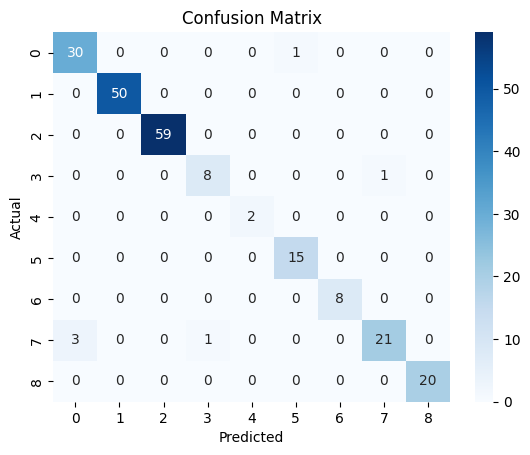

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


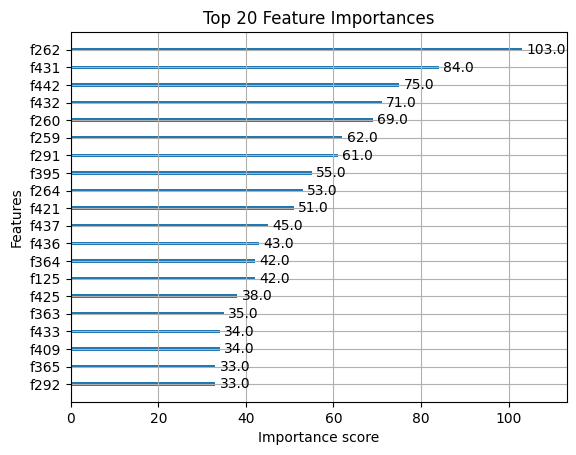

In [53]:
xgb.plot_importance(model, max_num_features=20)
plt.title("Top 20 Feature Importances")
plt.show()
